In [79]:
from statistics import mean

import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.svm import LinearSVR, SVR
from xgboost import XGBRegressor

from utils.ml_data_provider import SectoralDataProvider

In [2]:
def drop_outliers_iqr(df, iqr_bound=(0.25, 0.75), IQR_k=7):
    Q1 = df.quantile(iqr_bound[0])
    Q3 = df.quantile(iqr_bound[1])
    IQR = Q3 - Q1
    return df[~((df < (Q1 - IQR_k * IQR)) | (df > (Q3 + IQR_k * IQR))).any(axis=1)]
def drop_outliers_quantile(df, keep_inside_quantiles_bounds = (0.01, 0.99)):
    q_l = df.quantile(keep_inside_quantiles_bounds[0])
    q_u = df.quantile(keep_inside_quantiles_bounds[1])
    print(keep_inside_quantiles_bounds)
    return df[~((df < q_l) | (df > q_u)).any(axis=1)]

def visualise_data(df: pd.DataFrame, remove_outliers=True, remove_outliers_function=drop_outliers_quantile, remove_outliers_kwargs = None):
    df_to_visualize = df.copy()
    if remove_outliers:
        df_to_visualize = remove_outliers_function(df_to_visualize, **remove_outliers_kwargs)
        print(df.index.size - df_to_visualize.index.size)
    df_to_visualize.hist(bins=50, figsize=(20, 15))
    fig, axes = plt.subplots(5, int(np.ceil(len(df_to_visualize.columns) / 5)), figsize=(20, 15))
    for i,el in enumerate(list(df_to_visualize.columns.values)):
        df_to_visualize.boxplot([el], ax=axes.flatten()[i])
    plt.tight_layout()
    plt.show()
def eval(model, features, labels):
    predictions = model.predict(features)
    errors = abs(predictions - labels)
    mape = 100 * np.mean(errors / labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MSE:', f'{mean_squared_error(labels, predictions, squared=False)}')
    print('MAE:', f'{mean_absolute_error(labels, predictions)}')
    print('R^2:', f'{r2_score(labels, predictions)}')

In [71]:
data_provider = SectoralDataProvider(cache_path='/Users/j4yzer/PycharmProjects/VKR/data/sectoral_ml')
data : pd.DataFrame = data_provider.load_data()
data = data.replace([-np.Inf, np.Inf], np.nan)
data = data.dropna()
# train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
data_by_sector = data.groupby('sector')
split_data_by_sector = {sector: train_test_split(sector_data, test_size=0.05, shuffle=False) for sector, sector_data in data_by_sector}
train_data_by_sector = {k: v[0] for k, v in split_data_by_sector.items()}
test_data_by_sector = {k: v[1] for k, v in split_data_by_sector.items()}

train_data_by_sector = {k: drop_outliers_iqr(v.drop(['ticker', 'sector', 'sectoralIndex', 'date'], axis=1), IQR_k=30) for k, v in train_data_by_sector.items()}
y_train_by_sector = {k: v['nextPeriodRelativeToSectoralIndexReturn'] for k, v in train_data_by_sector.items()}
X_train_by_sector = {k: v.drop(['nextPeriodRelativeToSectoralIndexReturn'], axis=1) for k, v in train_data_by_sector.items()}

selected_features = ['absoluteReturn', 'relativeToSPReturn','relativeToSectoralIndexReturn', 'closePrice',
'freeCashFlowPerShare', 'bookValuePerShare', 'marketCap', 'priceToSalesRatio', 'currentRatio']

long_tail_columns = ['closePrice', 'bookValuePerShare', 'marketCap', 'priceToSalesRatio', 'currentRatio']
noraml_columns = [k for k in selected_features if k not in long_tail_columns]

select_features = FunctionTransformer(lambda x: x[selected_features])
long_tail_scaler = make_pipeline(PowerTransformer())
normal_scaler = make_pipeline(RobustScaler())

prep_pipeline = make_pipeline(select_features, ColumnTransformer([('lt', long_tail_scaler, long_tail_columns), ('normal', normal_scaler, noraml_columns)]))

random_forest_pipeline = make_pipeline(prep_pipeline, RandomForestRegressor(max_features=8, max_depth=5, n_estimators=300, bootstrap=True,random_state=42))

models_by_sector = {k: random_forest_pipeline.fit(X_train_by_sector[k], v) for k, v in y_train_by_sector.items()}

In [13]:
# TODO
# 1. Get periods.
# 2. foreach Iterate through them
#   2.1. foreach Iterate through each sector, select data for given period.
#   2.2. Predict using model nextRelativeToSectorReturn
#   2.3. Transform predictions to df, add ticker names. Sort and select top 5. Add top 5 to array: tops
#   2.4. end foreach
# 3. Calculate average nextRelativeToSPReturn value for tops array
# 4. add them to dict: period: value
# 5. end foreach

INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


dict_values([0.024655789108832978, 0.0024605582498758065, 0.11262523100253245, 0.08877372684473492])
mean 0.05712882630149404


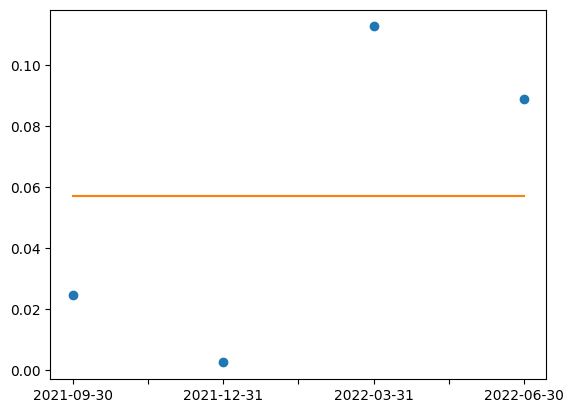

In [81]:
test_data_by_sector_merged : pd.DataFrame = pd.concat([v for k, v in test_data_by_sector.items()])
test_data_by_sector_merged['nextPeriodRelativeToSPReturn'] = test_data_by_sector_merged['relativeToSPReturn'].shift(-1)
test_data_by_date = test_data_by_sector_merged.groupby('date')
mean_returns = {}
for date, data_for_date in test_data_by_date:
    if data_for_date.index.size < 20:
        continue
    tops = []
    mean_by_sector = {}
    for sector, data_for_date_for_sector in data_for_date.groupby('sector'):
        preds = pd.DataFrame(models_by_sector[sector].predict(data_for_date_for_sector), columns=['score'], index=data_for_date_for_sector.index)
        preds.insert(loc=0, column='ticker', value=data_for_date_for_sector['ticker'])
        preds = preds.sort_values(by='score',ascending=False)
        score_mean = preds['score'].head(5).mean()
        tops.extend(preds['ticker'].head(5))
        mean_by_sector[sector] = score_mean
    returns = data_for_date[data_for_date['ticker'].isin(tops)][['sector', 'nextPeriodRelativeToSPReturn']]
    means : pd.DataFrame = returns.groupby('sector').mean()
    pr = pd.DataFrame([[k, v] for k, v in mean_by_sector.items()], columns=['sector', 'predicted_mean'])
    means = means.join(pr.set_index('sector'), on=['sector'])
    weights = means.transform(lambda x: x / x.sum())
    mean_returns[date] = returns['nextPeriodRelativeToSPReturn'].mean()
pd.Series(mean_returns).plot(kind='line', style=['o'])
print(mean_returns.values())
print('mean', mean(mean_returns.values()))
plt.plot(mean_returns.keys(), np.repeat(mean(mean_returns.values()),len(mean_returns.values())))

